In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import np_utils
import numpy as np
import nnModels
import main
import math
import helper

Using Theano backend.
/Users/harveytang/.virtualenvs/eye/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [19]:
data = np.load('data/fovealImages.npy')

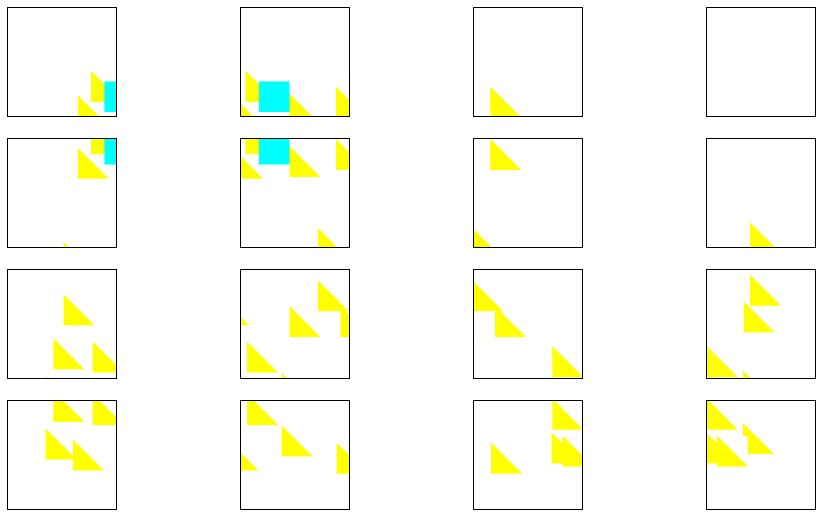

In [20]:
foo = helper.splitSectors(data[0])
fig = plt.figure(figsize=(16,9))
for sector_index in range(len(foo)):
    plt.subplot(4,4,sector_index+1)
    bar = helper.formRGBImage(foo[sector_index])
    plt.imshow(bar)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',        # ticks along the bottom edge are off
    right='off',       # ticks along the top edge are off
    labelleft='off')   # labels along the bottom edge are off

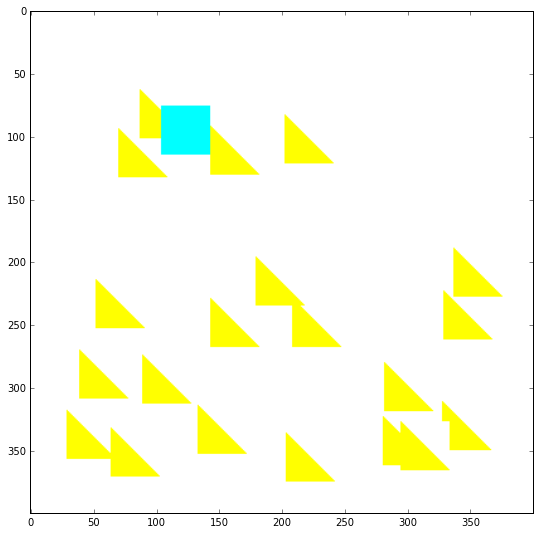

In [21]:
fig = plt.figure(figsize=(16,9))
plt.imshow(helper.formRGBImage(data[0]),cmap='gray')

In [37]:
peri = nnModels.PeripheryNet()
peri.load('100pOn90000')

In [2]:
peri_data = np.load('data/victorPeripheryImages.npy')
#peri_answers = np.load('data/peripheryIndexes.npy')
#peri_answers = np_utils.to_categorical(peri_answers, 16)

In [39]:
predictions = peri.predict(peri_data)
right = 0
topHalf = 0
for i, j in enumerate(predictions):
    if np.argmax(j) == np.argmax(peri_answers[i]):
        right += 1
    if np.argmax(peri_answers[i]) in np.argpartition(j, -8)[-8:]:
        topHalf += 1
print("First choice cases: {0}".format(float(right)/len(predictions)))
print("Top half of cases: {0}".format(float(topHalf)/len(predictions)))

First choice cases: 1.0
Top half of cases: 1.0


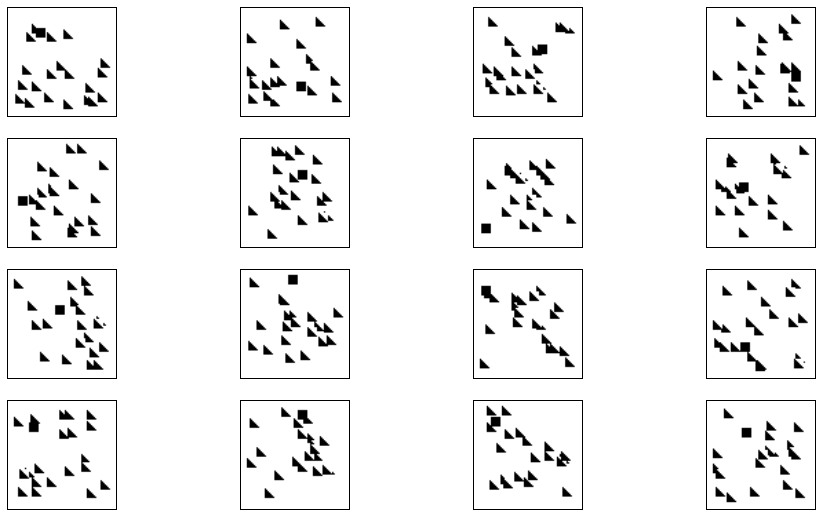

In [23]:
fig = plt.figure(figsize=(16,9))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(peri_data[i*25][0], cmap="gray")
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',        # ticks along the bottom edge are off
    right='off',       # ticks along the top edge are off
    labelleft='off')   # labels along the bottom edge are off

In [3]:
def corr2(a,b):
    a = a - np.mean(a)
    b = b - np.mean(b)

    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r

In [4]:
checkpoint = peri_data[0][0]
correlation = np.zeros(len(peri_data))
for i in range(len(peri_data)):
    correlation[i] = corr2(checkpoint, peri_data[i][0])

In [24]:
np.where(correlation==1.0)

(array([0]),)

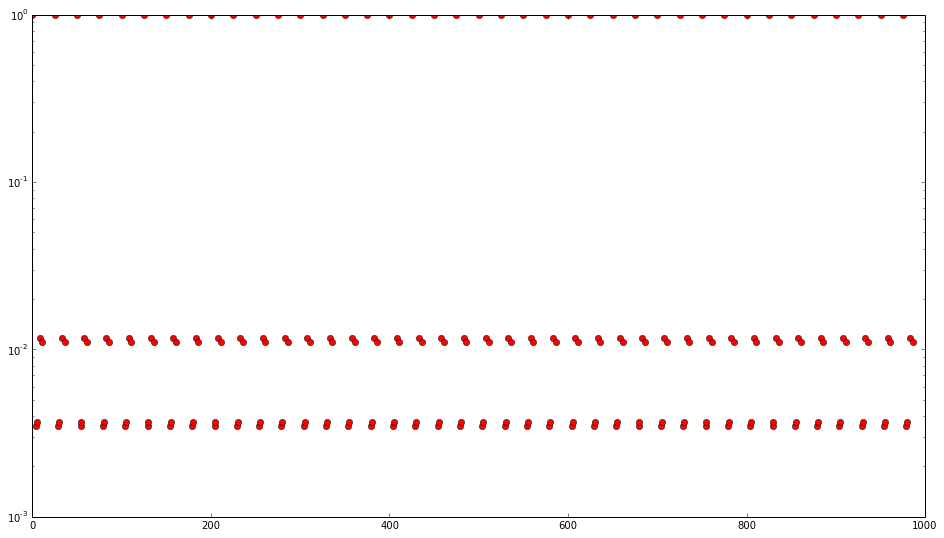

In [7]:
fig = plt.figure(figsize=(16,9),dpi=100)
plt.semilogy(correlation[:1000], 'ro')

In [ ]:
fovModel = nnModels.FoveaNet(main.foveDataGen(batch_size=1))

In [ ]:
fovModel.fit_generator(main.foveDataGen(batch_size=16), samples_per_epoch=1024, nb_epoch=3)

In [ ]:
fovData = list(main.foveDataGen(batch_size=30))
fovPredictions = fovModel.predict(fovData[:,0])
fovAnswers = fovData[:,1]

In [ ]:
np.max(fovPredictions)

AttributeError: 'module' object has no attribute 'formRGBImage'

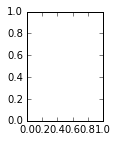

In [28]:
fig = plt.figure(figsize=(16,9))
for pred_index in range(40):
    plt.subplot(4,10,pred_index+1)
    bar = helper.formRGBImage(fovData[len(fovData)*3/4:][pred_index])
    plt.imshow(bar)
    plt.title("{0} - {1}".format(fovPredictions[pred_index][0] > 0.5, fovAnswers[len(fovAnswers)*3/4:][pred_index]))
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',        # ticks along the bottom edge are off
    right='off',       # ticks along the top edge are off
    labelleft='off')   # labels along the bottom edge are off